
## GridSearchCV and RandomSearchCV for Artificial Neural Networks

#### Ivan Feng
#### UT PGE
### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

Artificial neural networks (ANNs), also known as universal function approximators, are one of the most flexible and widely applicable ways to implement machine learning and model data. However, the main drawback is the computation cost due to the required hyperparameter optimization and number of hyperparameters. This project investigated and visually compared some commonly used hyperparameter optimization search methods such as GridSearch, RandomSearch, and BayesSearch. While all three methods provided similar optimal hyperparameters, it appears likely GridSearch requires the most iterations. It is possible that BayesSearch and RandomSearch will produce acceptable solutions in a faster time.



In [1]:
!pip install scikit-optimize
import os, time, random, warnings  
import numpy as np                        
import pandas as pd
import tensorflow as tf                       
import seaborn as sns         
import matplotlib.pyplot as plt           
from matplotlib.pyplot import figure               
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Activation, Dropout  
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as k
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from IPython.display import display
physical_devices = tf.config.list_physical_devices('GPU')
warnings.filterwarnings("ignore")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Functions

The following functions will be used in the workflow.

In [2]:
def plot_corr(dataframe,size=10):                         # given a dataframe,plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

def buildANN():                                           #basic ANN structure used in this project
    model = Sequential()
    model.add(Dense(units=5, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

def accuracyScore(orig,pred):                             #custom scoring function
    mape = np.mean(100 * (np.abs(orig-pred)/orig))        #calculates mean absolute percentage error
    return(100-mape)

def generateData():                                       #generates synthetic data based off equations relating production of an oil well to grain diameter, porosity, pressure, viscosity.... etc. 
  def getProduction(d, phi, hdPu):
    r=100
    k = d**2*phi**3 / (1-phi)**2.                         #Carmen Kozeny Equation for permeability                                                         
    q=k*hdPu/((np.log(r)-.75))                            #Darcy's law applied to an ideal radial well, single phase flow, r is the ratio of rE to rW, hdPu is a combined height, pressure difference and viscosity term
    #q= q*(1+(random.random()-.5)/10)                    #add some randomness to the production
    if q<0:                                               # any production below 0 is set to 0
      q=0
    return q
  data=[]
  for i in range(0, 2000):                                #create random values for predictor features
    d=random.randrange(1,100)/10
    phi = random.randrange(1,30)/100
    hdPu = random.randrange(1,100)/10
    temp=[d, phi, hdPu]
    prod = getProduction(*temp)                           #get production from random predictor features
    temp.append(prod)
    data.append(temp)

  data=pd.DataFrame(data)                           
  data.columns = ["d", "phi", "hdPu", "prod"]
  print("Unscaled Data")
  display(data.head())
  print("Count: " + str(len(data)))
  print("")

  scaler = StandardScaler()                               #standardize data to account for variations in magnitude between features
  scaler.fit(data)
  data=pd.DataFrame(scaler.transform(data))   
  data.columns = ["d", "phi", "hdPu", "prod"] 
  d_min = data['d'].values.min()
  d_max = data['d'].values.max()
  data['d'] = (data['d'] - d_min)/(d_max - d_min) * 2 - 1
  phi_min = data['phi'].values.min()
  phi_max = data['phi'].values.max()
  data['phi'] = (data['phi'] - phi_min)/(phi_max - phi_min) * 2 - 1
  hdPu_min = data['hdPu'].values.min()
  hdPu_max = data['hdPu'].values.max()
  data['hdPu'] = (data['hdPu'] - hdPu_min)/(hdPu_max - hdPu_min) * 2 - 1
  prod_min = data['prod'].values.min()
  prod_max = data['prod'].values.max()
  data['prod'] = (data['prod'] - prod_min)/(prod_max - prod_min) * 2 - 1
  print("Scaling:")
  display(data.describe().transpose()) 
  df=data          
  df.columns = ["d", "phi", "hdPu", "prod"]
  df = df.drop(df[df['prod'] < df["prod"].quantile(0.8)].sample(frac=.95).index)    #adjust distribution of production by removing some data points. Faster computation
  df = df.drop(df[df['prod'] > df["prod"].quantile(0.975)].sample(frac=1).index)
  print("Count: " + str(len(df)))
  return df

def plotContour(search):                                #given a search result, plot it
  result = pd.concat([pd.DataFrame(search.cv_results_["params"]),pd.DataFrame(search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
  fig, ax = plt.subplots(figsize = (10, 10))
  c=ax.tricontourf(result.iloc[:,0],result.iloc[:,1]   ,result.iloc[:,2], cmap = "viridis")
  ax.scatter(result.iloc[:,0], result.iloc[:,1], color = "black")
  plt.colorbar(c, label = "mean_test_score")
  ax.set_ylabel(result.columns[1])
  ax.set_xlabel(result.columns[0])
  plt.show()


### 1) Generate Data
Synthetic production data is generated as a function of various physical properties, using the functions written above (Carmen Kozeny, Darcy's Law for ideal radial well). The synthetic data is then scaled/pruned, and a correlation matrix plotted.

**Predictor Features**

d: grain diameter

phi: porosity

hdPu: height*(reservior pressure-wellbore pressure)/viscosity

r: radius of reservoir to radius of wellbore ratio

**Response Features**

prod: oil production

Unscaled Data


,d,phi,hdPu,prod
0,1.3,0.05,9.7,0.000589
1,6.7,0.10,7.1,0.102066
2,2.0,0.29,7.4,0.371471
3,7.9,0.26,4.0,2.078391
4,2.8,0.18,6.5,0.114650


Count: 2000

Scaling:


,count,mean,std,min,25%,50%,75%,max
d,2000.0,-0.004378,0.583068,-1.0,-0.510204,-2.040816e-02,0.469388,1.0
phi,2000.0,-0.000607,0.601834,-1.0,-0.571429,-1.110223e-16,0.500000,1.0
hdPu,2000.0,0.010643,0.581901,-1.0,-0.489796,2.040816e-02,0.510204,1.0
prod,2000.0,-0.909887,0.206447,-1.0,-0.999177,-9.900278e-01,-0.933632,1.0


Count: 468


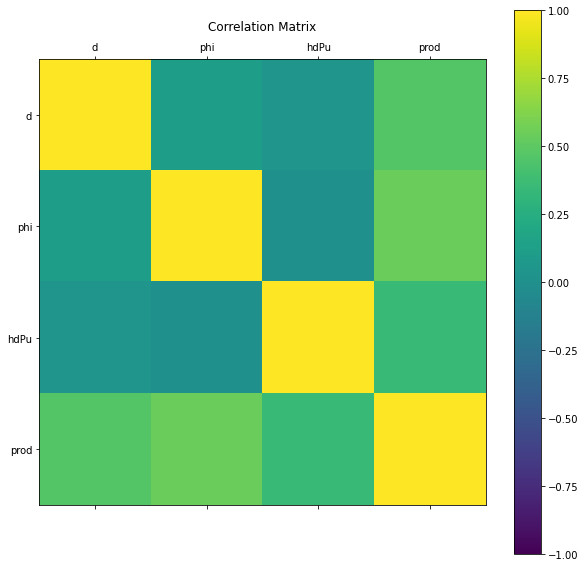

In [3]:
df=generateData()
plot_corr(df)

### 2) Visually Inspect Generated Data
Data is split into testing and training, and plotted to ensure that values and distributions look reasonable. 

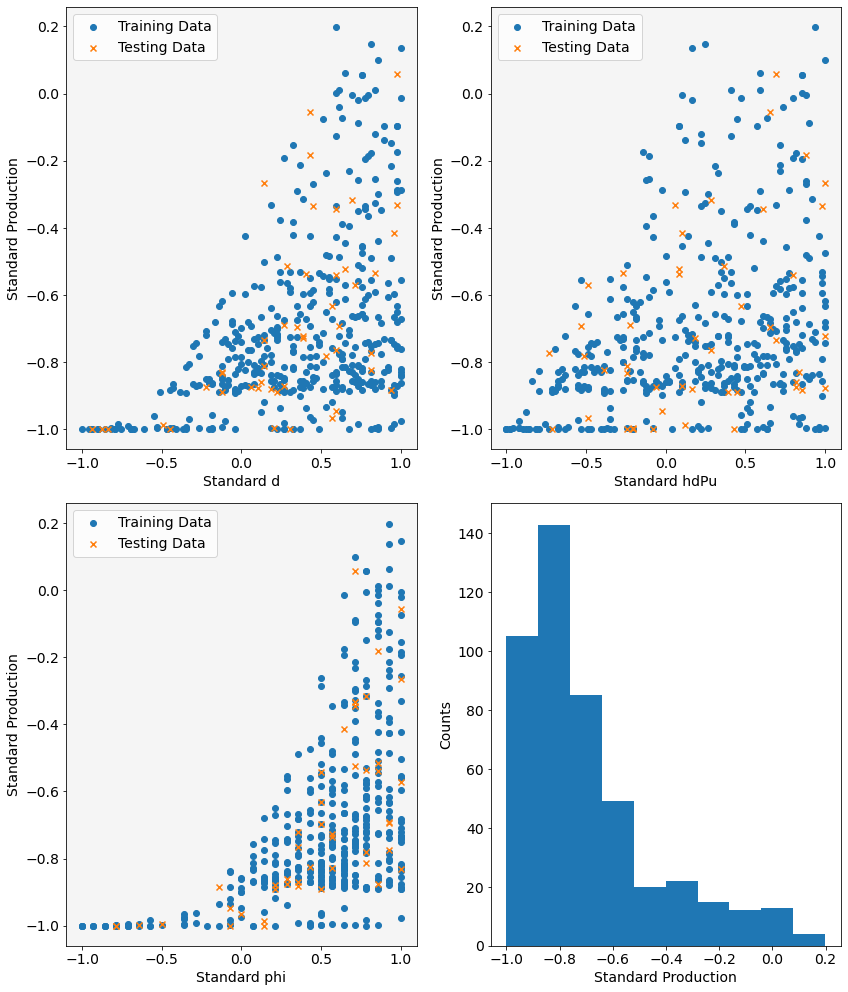

In [4]:
X = df.iloc[:,0:3]                       #get predictor features
Y = df.iloc[:,3]                         #get response feature, production
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)  #split; most data is put in training as search methods themselves do splitting. However, data leaking into the hyperparameters could be an issue. The 10% testing is to verifiy optimal hyperparameters
 
plt.rcParams.update({'font.size': 14})
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (6, 6))

for i in range(0, 3):                                   #plot points 
  ax[i%2,int(i/2)].scatter(X_train.iloc[:, i], y_train, label = "Training Data", marker = "o")
  ax[i%2,int(i/2)].scatter(X_test.iloc[:, i], y_test, label = "Testing Data", marker = "x")

  ax[i%2,int(i/2)].set_ylabel("Standard Production")
  ax[i%2,int(i/2)].set_xlabel("Standard " + str(df.columns[i]))
  ax[i%2,int(i/2)].legend(loc = "upper left")
  ax[i%2,int(i/2)].set_facecolor('whitesmoke')

ax[1,1].hist(Y)
ax[1,1].set_ylabel("Counts")
ax[1,1].set_xlabel("Standard Production")
fig.set_tight_layout(True)
fig.set_size_inches(12, 14)
plt.show()

###3) Perform GridSearchCV
A 5x5 parameter grid of batch sizes and epochs was created. A model using the architecture described above and a mean absolute percentage error scoring function were used in GridSearchCV to produce a grid of scores for each batch size and epoch combination. The running duration was saved. 

In [5]:
paramList={'batch_size':[75,100,125,150,200],'epochs':[300,400,500,600,700],}                 #create a grid of parameters, total of 5x5 for 25 different points
model=KerasRegressor(buildANN, verbose=0)                                                     #build model 
custom_Scoring=make_scorer(accuracyScore, greater_is_better=False)                            #build scorer
grid_search=GridSearchCV(estimator=model, param_grid=paramList, scoring=custom_Scoring, cv=4) #create search object
StartTime=time.time()                                                                         #log time
grid_search.fit(X,Y, verbose=0)                                                               #perform grid search
EndTime=time.time()

###4) Visualize GridSearchCV Results

The results for the parameter grid is printed, and the scores are plotted in a 2D heat map to visualize how the parameters affect the model. The locations of the parameters tested are marked with black dots on the map

Total time to run GridSearchCV: 10.026469620068868 mins
Best parameters on grid: {'batch_size': 100, 'epochs': 500}


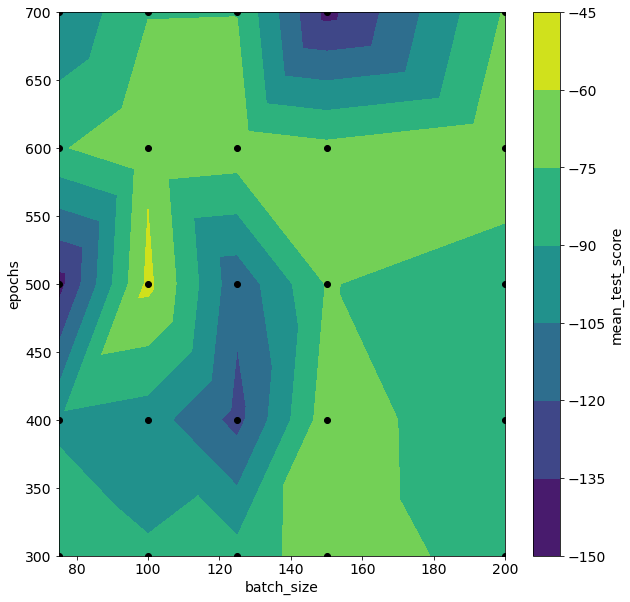

In [6]:
gridTime = (EndTime-StartTime)/60                                                             #record time
print("Total time to run GridSearchCV: " + str((EndTime-StartTime)/60)+ " mins")
print("Best parameters on grid: "+ str(grid_search.best_params_))
plotContour(grid_search)                                                                      #plot contour plots

###5) Plot and Verify GridSearch Optimized Model

The found optimal hyperparameters are used to build a model. The predicted production is compared to actual production visually. The MSE is calculated and printed.

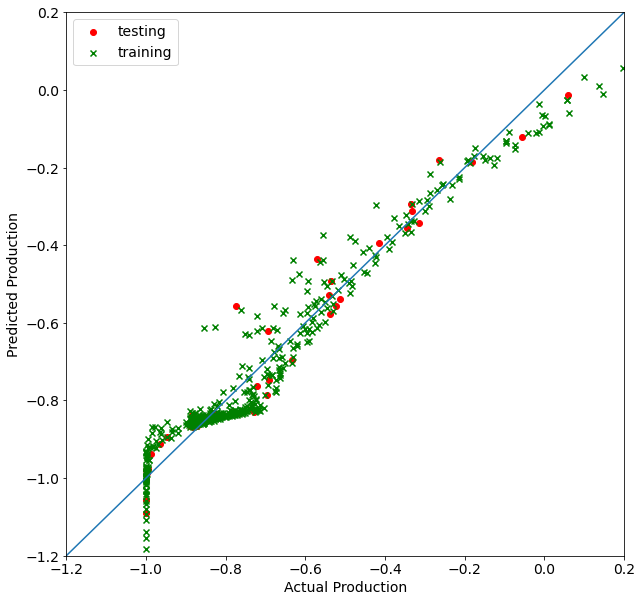

MSE: 0.0035081179730136586


In [12]:
model = KerasRegressor(buildANN,verbose=0)                                                    #here we build the model using the found optimal parameters from GridSearchCV, fit it, and plot both the training and testing dataset
model.fit(X_train,y_train, batch_size=100, epochs=500)
y_test_Pred = model.predict(X_test)
y_train_Pred = model.predict(X_train)
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(y_test, y_test_Pred, marker = "o", color = "red", label = "testing")
ax.scatter(y_train, y_train_Pred, marker = 'x', color = "green", label = "training")
ax.plot(np.linspace(-1.2,.2,10),np.linspace(-1.2,.2,10))
ax.set_xlabel("Actual Production")
ax.set_ylabel("Predicted Production")
ax.set_xlim(-1.2,.2)
ax.set_ylim(-1.2,.2)
ax.legend()
plt.show()
mse_krr = mean_squared_error(y_test_Pred,y_test)                                                #calculate the MSE
print("MSE: "+str(mse_krr))

###6) Perform RandomSearchCV
RandomSearch CV is done using a 100x100 grid of possible hyperparameters. 25 random points are selected to be tested.

In [18]:
paramList={'batch_size':np.linspace(75,200,100,dtype = int),'epochs':np.linspace(300,700,100,dtype = int),}       # here we create a much larger grid of possible paramters, with 100x100, or 10,000 different options. The points selected on this grid are random. 
model = KerasRegressor(buildANN,verbose=0)
custom_Scoring=make_scorer(accuracyScore, greater_is_better=False)
random_search=RandomizedSearchCV(estimator=model, param_distributions=paramList, scoring=custom_Scoring, cv=4,n_iter=25)
StartTime=time.time()
random_search.fit(X,Y, verbose=0)                                                                                 #fit the model
EndTime=time.time()


<ipython-input-18-3c3aad072aab>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(buildANN,verbose=0)


###7) Visualize RandomSearch Results

The results for the parameter grid is printed, and the scores are plotted in a 2D heat map to visualize how the parameters affect the model. The locations of the parameters tested are marked with black dots on the map. There are some differences with the result from GridSearch, with missing areas that are far from the randomly selected grid points with no data.

Total time to run random_searchCV: 6.607865719000499 mins
Best parameters on grid: {'epochs': 562, 'batch_size': 182}


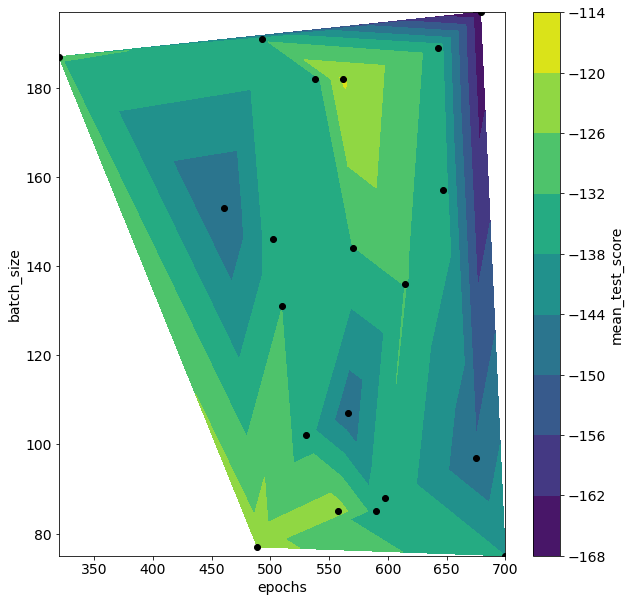

In [34]:
result = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)    #here we plot the results of RandomSearch
randomTime = (EndTime-StartTime)/60
print("Total time to run random_searchCV: " + str((EndTime-StartTime)/60)+ " mins")
print("Best parameters on grid: "+ str(random_search.best_params_))

fig, ax = plt.subplots(figsize = (10, 10))
c=ax.tricontourf(result.iloc[:,0],result.iloc[:,1]   ,result.iloc[:,2], cmap = "viridis")
ax.scatter(result.iloc[:,0], result.iloc[:,1], color = "black")
plt.colorbar(c, label = "mean_test_score")
ax.set_ylabel(result.columns[1])
ax.set_xlabel(result.columns[0])
plt.show()

###8) Plot and Verify RandomSearch Optimized Model

The found optimal hyperparameters are used to build a model. The predicted production is compared to actual production visually. The MSE is calculated and printed.

<ipython-input-26-46c88594cfb8>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(buildANN,verbose=0)


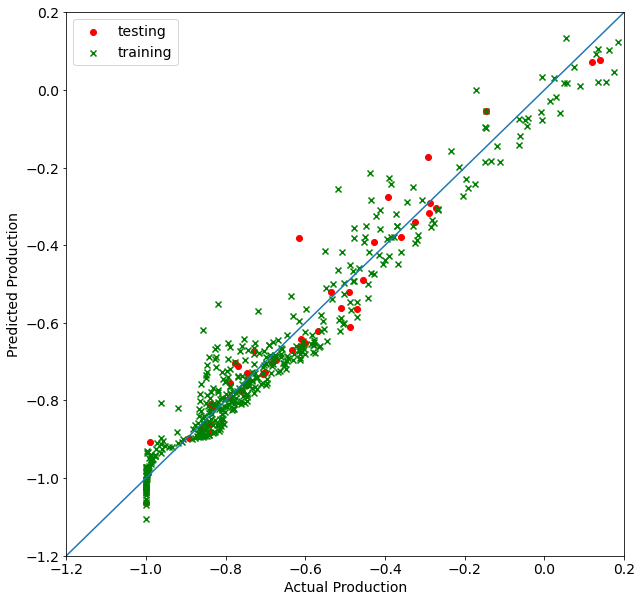

MSE: 0.0036909646980736355


In [26]:
model = KerasRegressor(buildANN,verbose=0)                                  #Using the optimal parameters found, build a model
model.fit(X_train,y_train, batch_size=182, epochs=562)
y_test_Pred = model.predict(X_test)
y_train_Pred = model.predict(X_train)
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(y_test, y_test_Pred, marker = "o", color = "red", label = "testing")
ax.scatter(y_train, y_train_Pred, marker = 'x', color = "green", label = "training")
ax.plot(np.linspace(-1.2,.2,10),np.linspace(-1.2,.2,10))
ax.set_xlabel("Actual Production")
ax.set_ylabel("Predicted Production")
ax.set_xlim(-1.2,.2)
ax.set_ylim(-1.2,.2)
ax.legend()
plt.show()
mse_krr = mean_squared_error(y_test_Pred,y_test)
print("MSE: "+str(mse_krr))

###9) Perform BayesSearch
BayesSearch CV is done using a 100x100 grid of possible hyperparameters. 25 random points are selected to be tested.

In [ ]:
paramList={'batch_size':np.linspace(75,200,100,dtype = int),'epochs':np.linspace(300,700,100,dtype = int),}           # here we do bayes search over a large fine grid of possible parameters
model = KerasRegressor(buildANN,verbose=0)
custom_Scoring=make_scorer(accuracyScore, greater_is_better=False)
Bayes_search=BayesSearchCV(estimator=model, search_spaces=paramList, scoring=custom_Scoring, cv=4,n_iter=25)
StartTime=time.time()
Bayes_search.fit(X,Y, verbose=0)
EndTime=time.time()


###10) Visualize BayesSearch Results

The results for the parameter grid is printed, and the scores are plotted in a 2D heat map to visualize how the parameters affect the model. The locations of the parameters tested are marked with black dots on the map. It seems like the resulting optimal solution is very close to the one produced by GridSearch. While there are still areas on the grid not covered, the selected points are much better spaced than RandomSearch.

Total time to run Bayes_searchCV: 6.607865719000499 mins
Best parameters on grid: OrderedDict([('batch_size', 96), ('epochs', 493)])


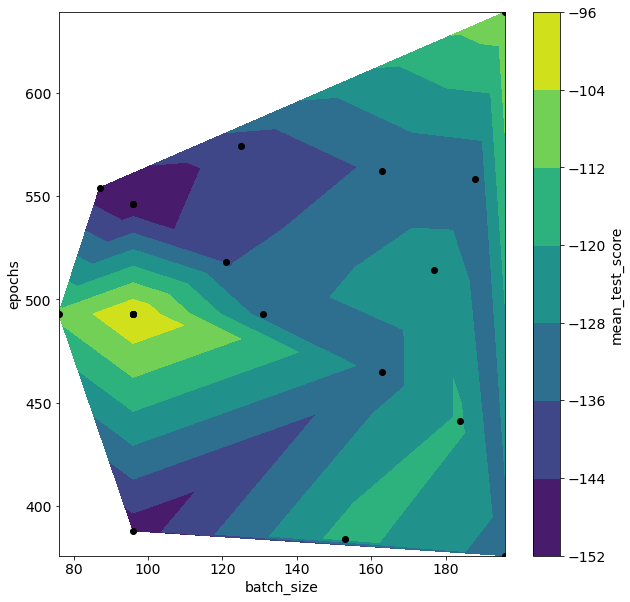

In [35]:
result = pd.concat([pd.DataFrame(Bayes_search.cv_results_["params"]),pd.DataFrame(Bayes_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)        #get the results and plot
BayesTime=(EndTime-StartTime)/60

print("Total time to run Bayes_searchCV: " + str((EndTime-StartTime)/60)+ " mins")
print("Best parameters on grid: "+ str(Bayes_search.best_params_))

fig, ax = plt.subplots(figsize = (10, 10))
c=ax.tricontourf(result.iloc[:,0],result.iloc[:,1]   ,result.iloc[:,2], cmap = "viridis")
ax.scatter(result.iloc[:,0], result.iloc[:,1], color = "black")
plt.colorbar(c, label = "mean_test_score")
ax.set_ylabel(result.columns[1])
ax.set_xlabel(result.columns[0])
plt.show()

###11) Plot and Verify BayesSearch Optimized Model

The found optimal hyperparameters are used to build a model. The predicted production is compared to actual production visually. The MSE is calculated and printed. Overall accruacy is high, and the testing data matches well.

<ipython-input-29-0c9337b7a82f>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(buildANN,verbose=0)


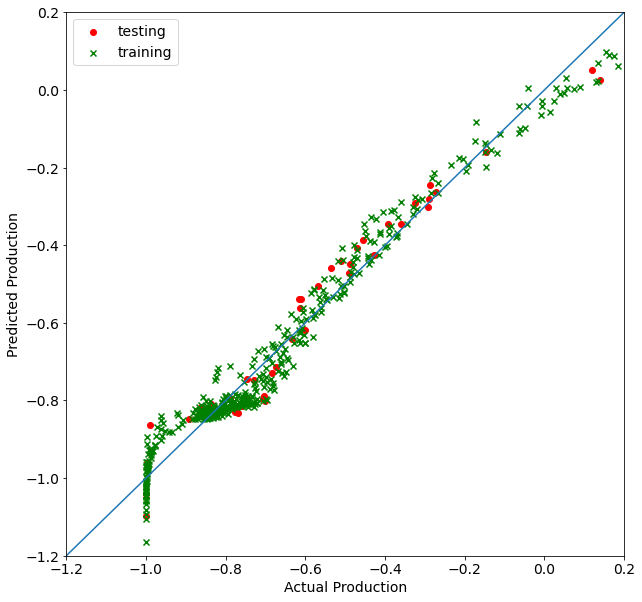

MSE: 0.0029949490917119226


In [29]:
model = KerasRegressor(buildANN,verbose=0)
model.fit(X_train,y_train, batch_size=96, epochs=493)
y_test_Pred = model.predict(X_test)
y_train_Pred = model.predict(X_train)

fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(y_test, y_test_Pred, marker = "o", color = "red", label = "testing")
ax.scatter(y_train, y_train_Pred, marker = 'x', color = "green", label = "training")
ax.plot(np.linspace(-1.2,.2,10),np.linspace(-1.2,.2,10))
ax.set_xlabel("Actual Production")
ax.set_ylabel("Predicted Production")
ax.set_xlim(-1.2,.2)
ax.set_ylim(-1.2,.2)
ax.legend()
plt.show()
mse_krr = mean_squared_error(y_test_Pred,y_test)
print("MSE: "+str(mse_krr))

###12) Results

A synthetic dataset of well production as a function of 3 physical parameters was created using common correlations and models. Artifical neural networks were then trained to perform multivariate regression on this dataset. Three different hyperparameter optimization methods, GridSearchCV, RandomSearchCV, and BayesSearchCV, were tested and compared using the same ANN structure and number of iterations. Contour plots of hyperparameter scores were plotted for each method, and the resulting model accruacy utilizing the optimal hyperparameters from each search method was also plotted. Overall, all 3 methods gave relatively similar optimal hyperparameters, and the final models all fit the data well; all MSE for predictions were around .003. However, it is likely that much fewer iterations were needed for Bayes Search or Random Search than grid search to find the same hyperparameters. 


<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Method</th>      <th>Batch Size</th>      <th>Epoch</th>      <th>Model MSE</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>GridSearch</td>     <td>100</td>      <td>500</td>      <td>0.0035</td>    </tr>    <tr>      <th>1</th>      <td>RandomSearch</td>      <td>182</td>      <td>562</td>      <td>0.0037</td>    </tr>    <tr>      <th>2</th>      <td>BayesSearch</td>      <td>96</td>      <td>493</td>      <td>0.0030</td>    </tr>  </tbody></table>


### Parting Comments / Promoting

Overall, one major issue was the reproducibility of the results. Due to the randomness inherent in the process, re-running code would produce slightly different graphs and points. The data also being randomly generated also was a possible effect.
 
Another issue is the variation in computing time on Google Colab, depending on how much time you've used it for the day. Restrictions on heavy use seemed like it would slow down runtimes.
 

About me:

Graduate student in PGE with interest in software and data science. Check out my github for other projects I've done in the past, such as simulations using numerical methods, kriging visualizers, or sudoku game/solver.

https://github.com/fengivan



___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
